In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
class HodgkinHuxley():
  """Hodgkin-Huxley Model implemented in Python

    Originally taken from the OpenWorm project (https://github.com/openworm)
    and modified by Diego L. Guarin (https://github.com/dguari1)

  """
  def __init__(self,t, inj_current, C_m=1.0, g_Na = 120.0, g_K=36.0, g_L = 0.3, E_Na = 50.0, E_K = 77, E_L = -54.387):

    self.C_m  =   C_m #membrane capacitance, in uF/cm^2

    self.g_Na = g_Na #Sodium (Na) maximum conductances, in mS/cm^2

    self.g_K  =  g_K #Postassium (K) maximum conductances, in mS/cm^2

    self.g_L  =   g_L #Leak maximum conductances, in mS/cm^2

    self.E_Na =  E_Na #Sodium (Na) Nernst reversal potentials, in mV

    self.E_K  = E_K #Postassium (K) Nernst reversal potentials, in mV

    self.E_L  = E_L #Leak Nernst reversal potentials, in mV

    self.t =  t # integration time and time steps

    self.inj_current = inj_current #injection current

    self.delta = int(1/(t[1]))


  def alpha_m(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

  def beta_m(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 4.0*np.exp(-(V+65.0) / 18.0)

  def alpha_h(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.07*np.exp(-(V+65.0) / 20.0)

  def beta_h(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

  def alpha_n(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

  def beta_n(self, V):
    """Channel gating kinetics. Functions of membrane voltage"""
    return 0.125*np.exp(-(V+65) / 80.0)

  def I_Na(self, V, m, h):
    """
    Sodium membrane current (in uA/cm^2)

    """
    return self.g_Na * m**3 * h * (V - self.E_Na)

  def I_K(self, V, n):
    """
    Potassium membrane current (in uA/cm^2)

    """
    return self.g_K  * n**4 * (V - self.E_K)

  def I_L(self, V):
    """
    Leak membrane current (in uA/cm^2)

    """
    return self.g_L * (V - self.E_L)

  # def I_inj(self, t):
  #   """
  #   External Current

  #   For example:
  #   step up to 10 uA/cm^2 at t>100
  #   step down to 0 uA/cm^2 at t>200
  #   step up to 35 uA/cm^2 at t>300
  #   step down to 0 uA/cm^2 at t>400

  #   """
  #   return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)

  def I_inj(self, t):
    """
    external current (in uA/cm^2)

    """

    index = np.argmin(np.abs(self.t - t))
    return self.inj_current[index]


  @staticmethod
  def dALLdt(X, t, self):
    """
    Integrate
    """
    V, m, h, n = X

    dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
    dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
    dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
    dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

  def results(self):
    """
    Main demo for the Hodgkin Huxley neuron model
    """

    X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))

    V = X[:,0]
    m = X[:,1]
    h = X[:,2]
    n = X[:,3]
    i_na = self.I_Na(V, m, h)
    i_k = self.I_K(V, n)
    i_l = self.I_L(V)


    return self.t, V, m, h, n , i_na, i_k,i_l




class injection_current():

  def step(t,t0,duration,max=10):

    index = np.argwhere((t>=t0) & (t<=t0+duration))
    out = np.zeros(np.size(t))
    out[index] = max
    return out

  def twostep(t,t0,t1,duration,v1=10,v2=50):

    index1 = np.argwhere((t>=t0) & (t<=t0+duration))
    index2 = np.argwhere((t>=t1) & (t<=t1+duration))
    out = np.zeros(np.size(t))
    out[index1] = v1
    out[index2] = v2
    return out


  def rampup(t,t0,tend,min=10,max=30):

    index = np.argwhere((t>=t0) & (t<=tend))
    out = np.zeros(np.size(t))
    out[index] = np.expand_dims(np.linspace(min,max,len(index)), axis=1)
    return out






(-1.0, 16.0)

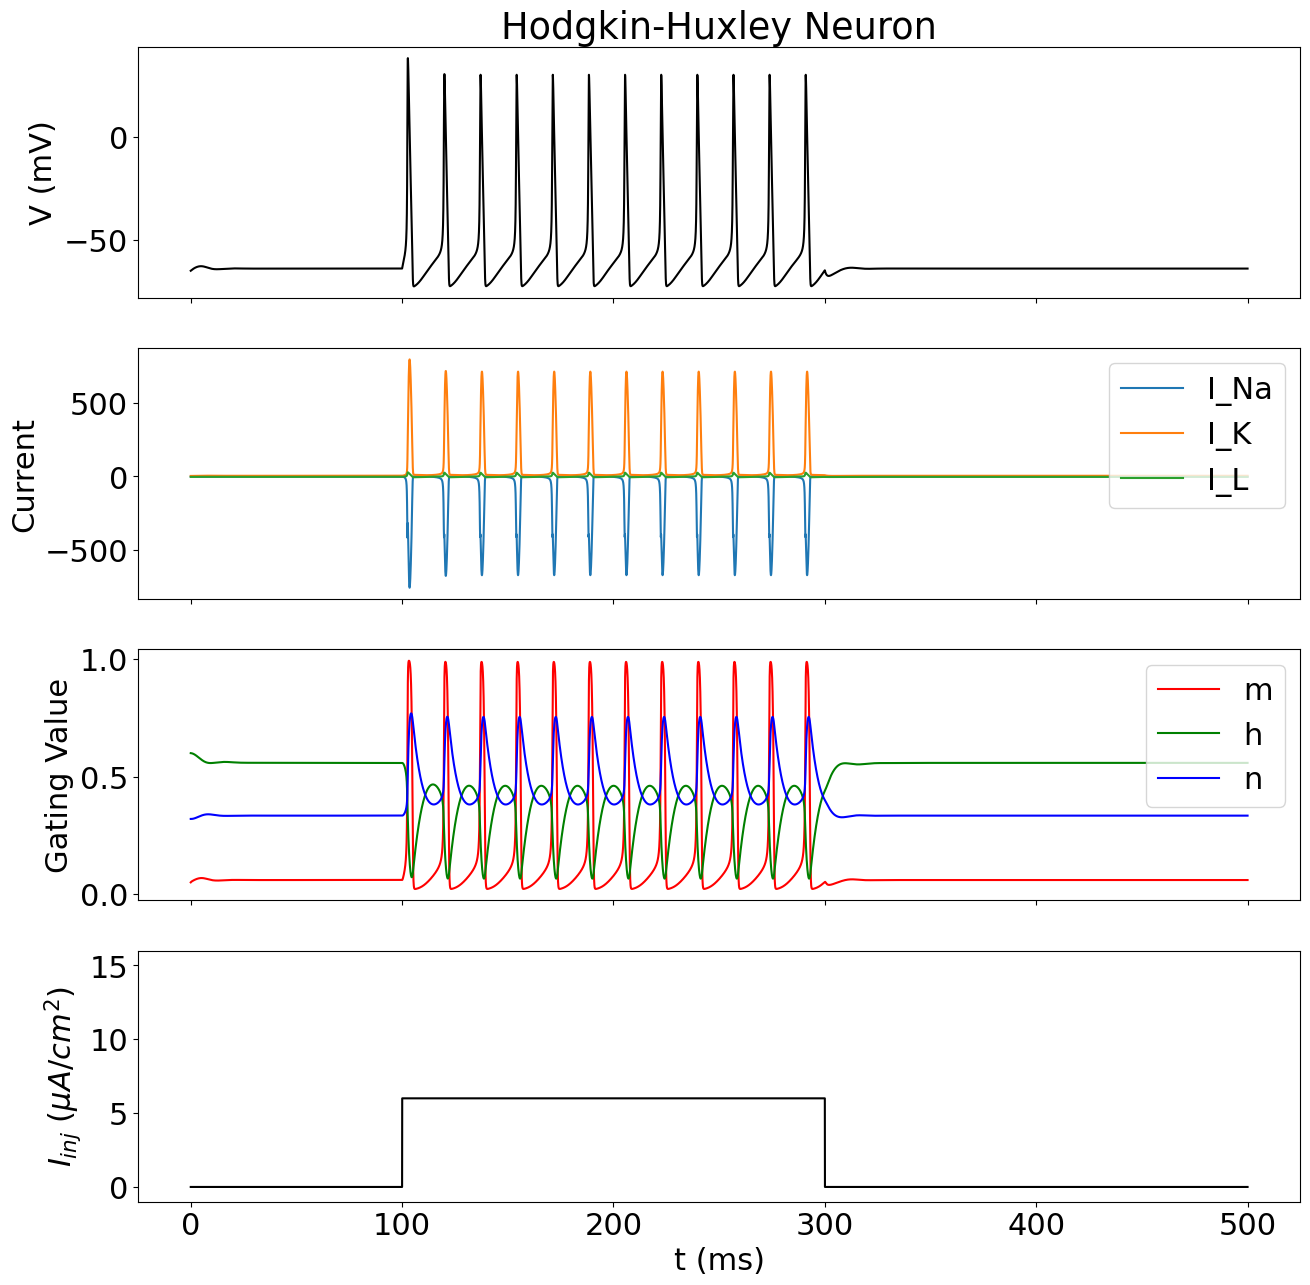

In [3]:
# create time vector
tmax = 500 # in miliseconds
tdelta= 0.01
t = np.linspace(0,tmax,int(tmax/tdelta))

max = 6
inj_current = injection_current.step(t,100,200,max)

#inj_current = injection_current.twostep(t,50,300,100,10,50)

#min = 10
#max = 100
#inj_current = injection_current.rampup(t,50,450,min,max)
#

model = HodgkinHuxley(t = t, inj_current = inj_current, E_K = -74)
t, V, m, h, n , i_na, i_k,i_l = model.results()


fig, ax = plt.subplots(4,  figsize=(15,15), sharex = True)


ax[0].set_title('Hodgkin-Huxley Neuron')
ax[0].plot(t, V, 'k')
ax[0].set_ylabel('V (mV)')

ax[1].plot(t, i_na, label='I_Na')
ax[1].plot(t, i_k, label='I_K')
ax[1].plot(t, i_l, label='I_L')
ax[1].set_ylabel('Current')
ax[1].legend()

ax[2].plot(t, m, 'r', label='m')
ax[2].plot(t, h, 'g', label='h')
ax[2].plot(t, n, 'b', label='n')
ax[2].set_ylabel('Gating Value')
ax[2].legend()


ax[3].plot(t, inj_current, 'k')
ax[3].set_xlabel('t (ms)')
ax[3].set_ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
ax[3].set_ylim(-1, np.max(inj_current)+10)

# plt.show()
